In [184]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats.mstats import normaltest

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split, KFold, cross_val_predict
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

sns.set_context('notebook')

In [185]:
data = pd.read_csv('/home/schubham/Documents/Data Science/insurance.csv')
len(data)

1338

In [186]:
data.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [187]:
data['smoker'].value_counts()

no     1064
yes     274
Name: smoker, dtype: int64

In [188]:
columns = data.select_dtypes(exclude='object').columns.to_list()


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


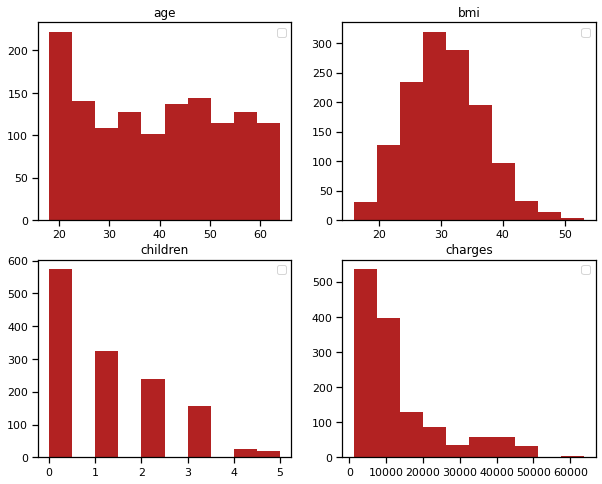

In [189]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,8))
axes= axes.ravel()
columns = data.select_dtypes(exclude='object').columns.to_list()

for ax, col in zip(axes,columns):
    ax.hist(data[col], color ='firebrick')
    ax.legend()
    ax.set_title(col)

<AxesSubplot:xlabel='children', ylabel='charges'>

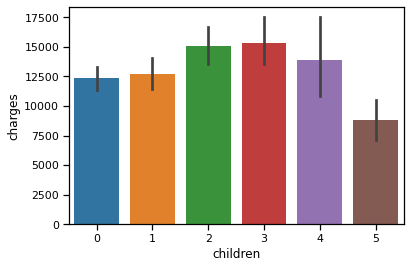

In [190]:
# fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,8))
# axes= axes.ravel()
# columns = data.select_dtypes(exclude='object').columns.to_list()

# for ax, col in zip(axes,columns):
#     sns.regplot(x=col,y='charges', ax=ax, data=data, label=col)
#     ax.legend()


sns.barplot(x=data['children'], y = data['charges'])

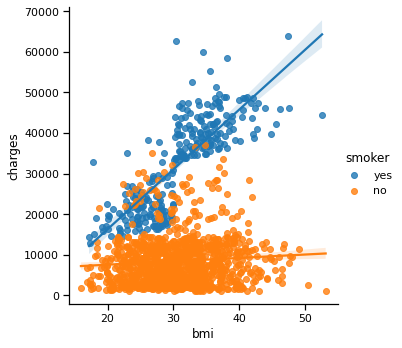

In [191]:
sns.lmplot(x='bmi', y='charges', data=data, hue='smoker')

## Feature transformation

### Checking normlity 

In [192]:
# Using D'Agostino K^2 test
normaltest(data['charges'])

NormaltestResult(statistic=336.8851220567733, pvalue=7.019807901276197e-74)

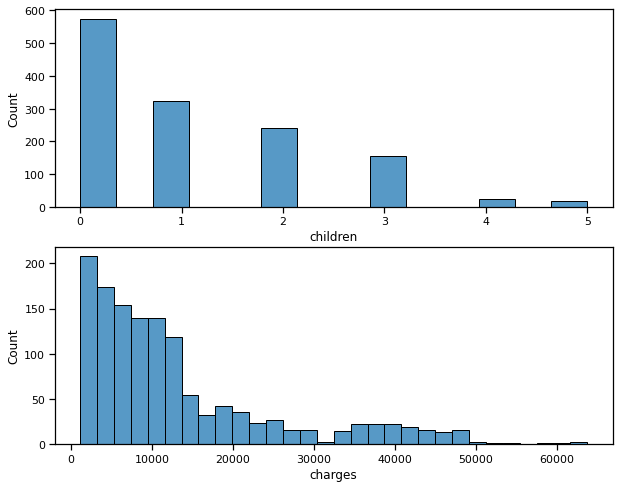

In [193]:
# checking for skewness:
numeric_data = data.select_dtypes(include='number')
numeric_data.skew()
skewed_cols = numeric_data.columns[abs(numeric_data.skew())>0.75].to_list()
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10,8))
for i,ax in zip(skewed_cols,axes):
    sns.histplot(data=data, x=i, ax=ax)



### High skewness and p values suggest that the distribution is not normal

### Variables are transformed using log transformation

<AxesSubplot:xlabel='charges', ylabel='Count'>

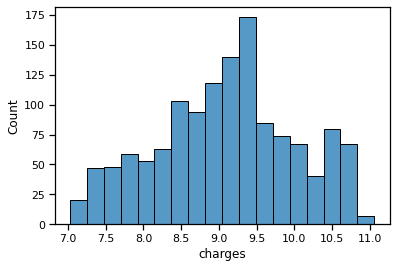

In [194]:
for i in skewed_cols:
    data[i] = np.log1p(data[i])
sns.histplot(data = data, x='charges')

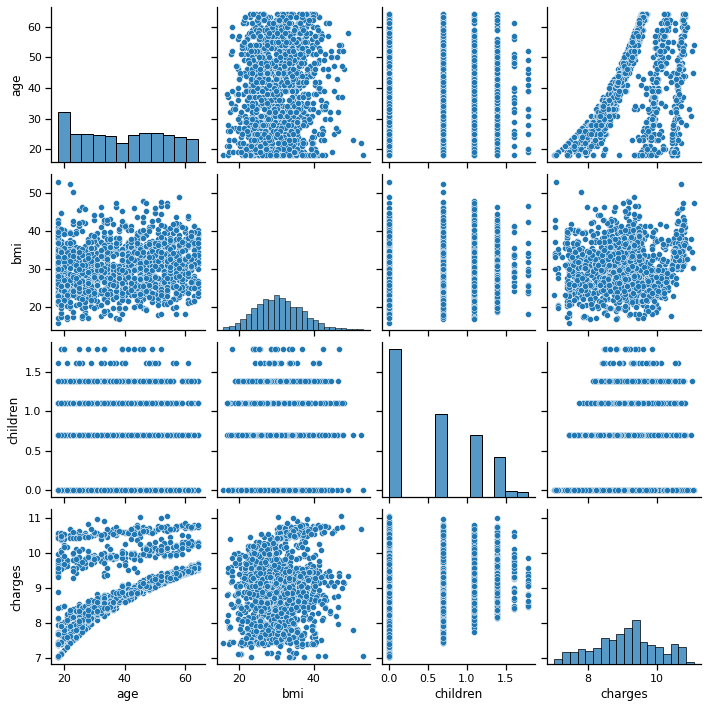

In [195]:
# Fill the null values by 0 or appropriate agg value 
num_cols = data.select_dtypes(include='number')
sns.pairplot(data=num_cols)

### Encoding categorical variables using pd.get_dummies()

In [196]:
data = pd.get_dummies(data, columns=['sex', 'smoker', 'region'])
data

,age,bmi,children,charges,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest
0,19,27.900,0.000000,9.734236,1,0,0,1,0,0,0,1
1,18,33.770,0.693147,7.453882,0,1,1,0,0,0,1,0
2,28,33.000,1.386294,8.400763,0,1,1,0,0,0,1,0
3,33,22.705,0.000000,9.998137,0,1,1,0,0,1,0,0
4,32,28.880,0.000000,8.260455,0,1,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1333,50,30.970,1.386294,9.268755,0,1,1,0,0,1,0,0
1334,18,31.920,0.000000,7.699381,1,0,1,0,1,0,0,0
1335,18,36.850,0.000000,7.396847,1,0,1,0,0,0,1,0
1336,21,25.800,0.000000,7.605365,1,0,1,0,0,0,0,1


### We see that there is a relationship between age and charges. PlolynomialFeatures could be of use here.

In [197]:
poly_feature = ['age']
pf = PolynomialFeatures(degree=2)
pf.fit(data[poly_feature])

new = pd.DataFrame(pf.transform(data[poly_feature]), columns = pf.get_feature_names(input_features=poly_feature))
new=new.drop(['1','age'], axis=1)
new
#data = pd.concat([data, new], axis=0, join='outer')
#data
data_new = data.join(new)
data_new

/home/schubham/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,age,bmi,children,charges,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest,age^2
0,19,27.900,0.000000,9.734236,1,0,0,1,0,0,0,1,361.0
1,18,33.770,0.693147,7.453882,0,1,1,0,0,0,1,0,324.0
2,28,33.000,1.386294,8.400763,0,1,1,0,0,0,1,0,784.0
3,33,22.705,0.000000,9.998137,0,1,1,0,0,1,0,0,1089.0
4,32,28.880,0.000000,8.260455,0,1,1,0,0,1,0,0,1024.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1333,50,30.970,1.386294,9.268755,0,1,1,0,0,1,0,0,2500.0
1334,18,31.920,0.000000,7.699381,1,0,1,0,1,0,0,0,324.0
1335,18,36.850,0.000000,7.396847,1,0,1,0,0,0,1,0,324.0
1336,21,25.800,0.000000,7.605365,1,0,1,0,0,0,0,1,441.0


### 1) Using linear regression and KFolds to make a prediction

In [198]:
X = data_new.drop('charges', axis=1)
y = data_new['charges']

In [199]:
# Creating a Kfolds object
kf = KFold(shuffle=True, random_state=72018, n_splits=5)
# Creating a standard scalar object
sc = StandardScaler()
# Creating a linear regression object
lr = LinearRegression()

In [200]:
# Creating a pipeline
estimator= Pipeline([('scalar', sc),
                    ('linear regression', lr)])
# we have skipped polynomial transform as it was performed before

In [201]:
# # Making predictions
# predictions = cross_val_predict(estimator, X, y, cv=kf)
# r2_score(y, predictions)

In [202]:
Scores = []
for train_index, test_index in kf.split(X):
    
    train_x, test_x, train_y, test_y = (X.iloc[train_index,:],
                                       X.iloc[test_index,:],
                                       y[train_index],
                                       y[test_index])
                
    estimator.fit(train_x, train_y)
    y_pred = estimator.predict(test_x)
    score = r2_score(test_y.values, y_pred)
    Scores.append(score)


In [203]:
# The mean r^2 score for linear regression:
print(f'The R^2 score for the linear regression model is :{np.round(np.mean(Scores),4)}')

The R^2 score for the linear regression model is :0.7636


### 2) Using GridsearchCV to find hyperparameters for Ridge/LASSO regression

In [204]:
# Defining a parameter grid for hyperparameters to be used in Ridge and LASSO
# Adding the polunomial features to the pipeline now

X = data.drop('charges', axis=1)
y = data['charges']

best_estimator = Pipeline([('PolyFeatures', pf),
                            ('scaler', sc),
                            ('Lasso', Lasso(max_iter=10000))])

parameters = {'PolyFeatures__degree': [1,2,3,],
             'Lasso__alpha': np.geomspace(1e-8,1, 8)}
grid = GridSearchCV(best_estimator, parameters, cv=kf)

In [205]:
grid.fit(X,y)

/home/schubham/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.325e+00, tolerance: 9.118e-02
  model = cd_fast.enet_coordinate_descent(
/home/schubham/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.831e+00, tolerance: 8.996e-02
  model = cd_fast.enet_coordinate_descent(
/home/schubham/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Du

/home/schubham/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.104e+01, tolerance: 9.055e-02
  model = cd_fast.enet_coordinate_descent(
/home/schubham/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.417e+01, tolerance: 8.945e-02
  model = cd_fast.enet_coordinate_descent(
/home/schubham/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Du

GridSearchCV(cv=KFold(n_splits=5, random_state=72018, shuffle=True),
             estimator=Pipeline(steps=[('PolyFeatures', PolynomialFeatures()),
                                       ('scaler', StandardScaler()),
                                       ('Lasso', Lasso(max_iter=10000))]),
             param_grid={'Lasso__alpha': array([1.00000000e-08, 1.38949549e-07, 1.93069773e-06, 2.68269580e-05,
       3.72759372e-04, 5.17947468e-03, 7.19685673e-02, 1.00000000e+00]),
                         'PolyFeatures__degree': [1, 2, 3]})

In [206]:
grid.best_score_, grid.best_params_

(0.8332500465387993,
 {'Lasso__alpha': 0.0003727593720314938, 'PolyFeatures__degree': 2})

In [207]:
y_predict_lasso = grid.predict(X)
# r^2 score for Lasso regression
print(f'The R^2 score for the LASSO regression model is :{np.round(r2_score(y, y_predict_lasso),4)}')

The R^2 score for the LASSO regression model is :0.8438


### Using GridSerchCV for Ridge regression

In [208]:
# Defining a parameter grid for hyperparameters to be used in Ridge and LASSO
# Adding the polunomial features to the pipeline now

X = data.drop('charges', axis=1)
y = data['charges']

best_estimator = Pipeline([('PolyFeatures', pf),
                            ('scaler', sc),
                            ('Ridge', Ridge(max_iter=10000))])

parameters = {'PolyFeatures__degree': [1,2,3,],
             'Ridge__alpha': np.geomspace(1,50, 8)}
grid = GridSearchCV(best_estimator, parameters, cv=kf)

In [209]:
grid.fit(X,y)

GridSearchCV(cv=KFold(n_splits=5, random_state=72018, shuffle=True),
             estimator=Pipeline(steps=[('PolyFeatures', PolynomialFeatures()),
                                       ('scaler', StandardScaler()),
                                       ('Ridge', Ridge(max_iter=10000))]),
             param_grid={'PolyFeatures__degree': [1, 2, 3],
                         'Ridge__alpha': array([ 1.        ,  1.74867862,  3.05787692,  5.347244  ,  9.35061127,
       16.35121402, 28.5930184 , 50.        ])})

In [210]:
y_pred_ridge = grid.predict(X)
grid.best_score_, grid.best_params_

(0.8329027673589582,
 {'PolyFeatures__degree': 2, 'Ridge__alpha': 3.057876921606392})

In [211]:
print(f'The R^2 score for the LASSO regression model is :{np.round(r2_score(y, y_pred_ridge),4)}')

The R^2 score for the LASSO regression model is :0.8437


## Summary: 
### We have bulit a regression model to predict the personal mediacal health insurance cost based on various features such as bmi, age , gender etc. using simple, LASSO and Ridge regression
### By taking a look at the r^2 score, we can say that the LASSO and Ridge regression give a better r^2 and subsequently a better model.